In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from lags import lag_dataset

In [2]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(start="2010-01-01", end="2025-07-29", interval="1d")
msft_df = msft_df.drop(columns=["Dividends", "Stock Splits"])
msft_df.index = msft_df.index.tz_localize(None)

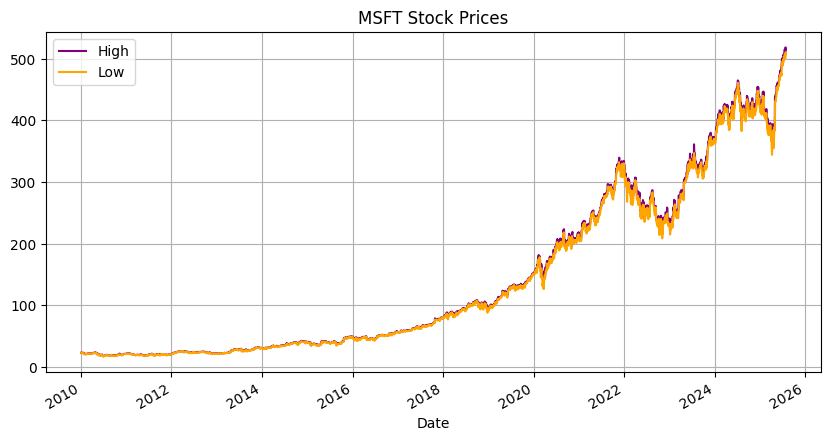

In [3]:
plt.subplots(figsize=(10, 5))
msft_df['High'].plot(label='High', color='purple')
msft_df['Low'].plot(label='Low', color='Orange')
plt.title('MSFT Stock Prices')
plt.grid()
plt.legend()

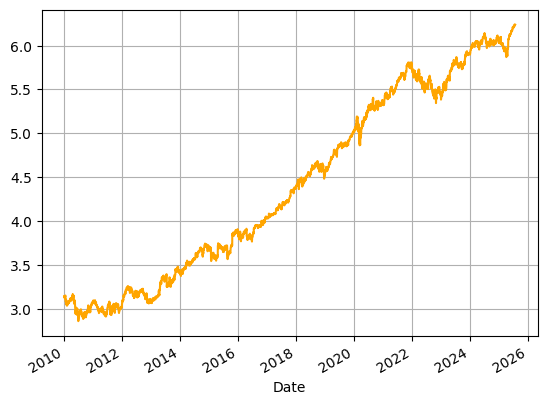

In [4]:
# log data plot
np.log(msft_df['Close']).plot(label='Log Returns', color='orange')
plt.grid()

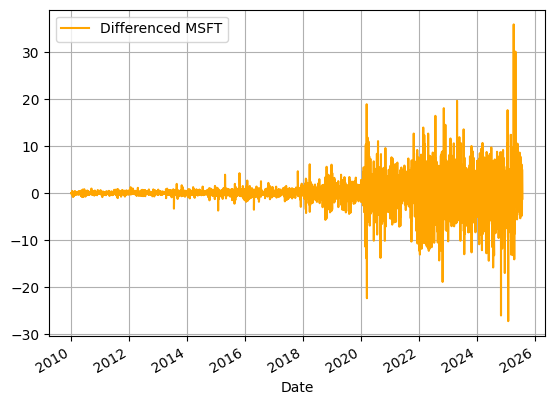

In [5]:
# checking differenced data stationarity; we still need to improve
differentiated_y = msft_df['Close'].diff().dropna().plot(label='Differenced MSFT', color='orange')
plt.grid()
plt.legend()

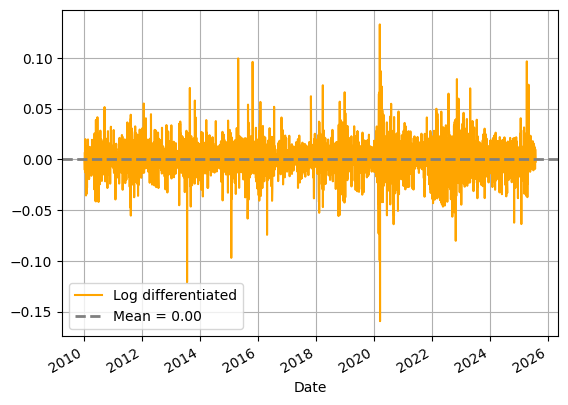

In [6]:
# Check differenced log data stationarity
np.log(msft_df['Close']).diff().dropna().plot(label='Log differentiated', color='orange')
m = np.log(msft_df['Close']).diff().dropna().mean()
plt.axhline(m,
           color='gray',
           linestyle='--',
           linewidth=2,
           label=f'Mean = {m:.2f}')
plt.grid()
plt.legend()

# 1. Split the data for train-test

In [12]:
# 1. Build your lagged features
split_date = pd.Timestamp("2015-03-04")
lag_data   = lag_dataset(msft_df, lags=1, cols=['Close'])  # shape: (T, 30) if you have 3 cols × 10 lags

# 2. Take logs (optionally add a small constant if you have zeros)
lag_data_log = np.log(lag_data)
price_log    = np.log(msft_df["Close"])

# 3. Split features & target
X_train = lag_data_log.loc[: split_date - pd.Timedelta(days=1)]
X_test  = lag_data_log.loc[split_date :]

y_train = price_log.loc[X_train.index]    # align on the SAME dates
y_test  = price_log.loc[X_test.index]

# 4. (Optional) drop any rows with NaNs after alignment
train_idx = X_train.dropna().index
X_train   = X_train.loc[train_idx]
y_train   = y_train.loc[train_idx]

test_idx  = X_test.dropna().index
X_test    = X_test.loc[test_idx]
y_test    = y_test.loc[ test_idx]


In [34]:
# 5. Fit a Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Create a daily prediction for the next 30 days, by recursively using the data
last_feat = X_train.iloc[-1:].copy()
recursive_preds = []
for i in range(X_test.shape[0]):
    pred = lr.predict(last_feat)[0]
    recursive_preds.append(pred)
    last_feat["Close_lag_1"] = pred

last_date = X_test.index[0]
future_index = pd.bdate_range(start=last_date, periods=X_test.shape[0])
pred_series_log = pd.Series(recursive_preds, index=future_index, name="Recursive Prediction (log)")

print("Test MSE for log:", mean_squared_error(y_test, pred_series_log))
print("Test  R²:", r2_score(y_test, pred_series_log))

print("Test MSE:", mean_squared_error(np.exp(y_test), np.exp(pred_series_log)))

Test MSE for log: 2.4003950530092886
Test  R²: -2.7971757018404926
Test MSE: 42362.03920360113


In [35]:
lr.coef_, lr.intercept_

(array([0.99922456]), np.float64(0.0028630650697643034))

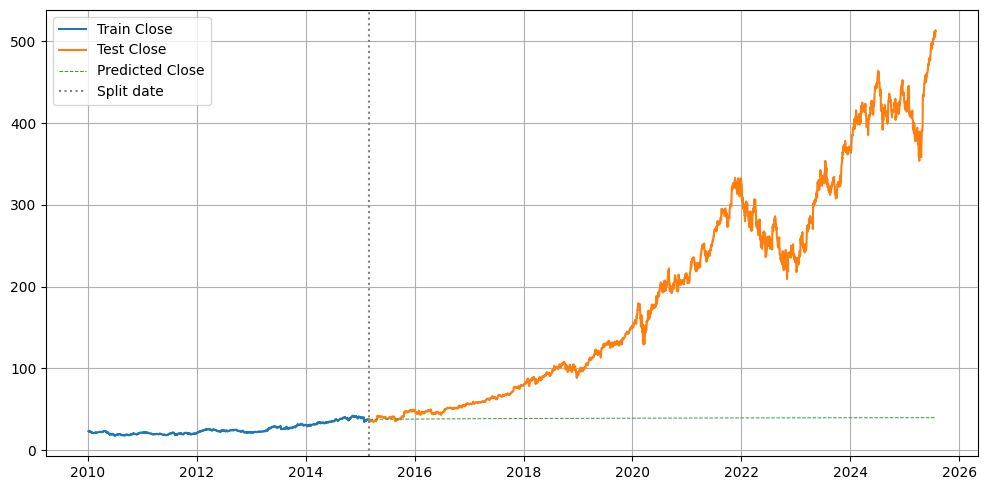

In [36]:
# 7. (Optional) plot actual vs. predicted
plt.figure(figsize=(10,5))
plt.plot(y_train.index, np.exp(y_train),  label="Train Close", color="C0")
plt.plot(y_test.index, np.exp(y_test),  label="Test Close",  color="C1")
plt.plot(y_test.index, np.exp(pred_series_log),  label="Predicted Close", linestyle="--", color="C2", linewidth=0.7)
plt.axvline(split_date, linestyle=":", color="gray", label="Split date")
plt.grid()
plt.legend(); plt.tight_layout(); plt.show()
